# WMIR practice lesson

### Objective
Train an SVM model on different datasets, optimized some parameters and compare the different outcomes.  
We will use the 20newsgroups dataset and the QuestionClassification.

#### Author
Claudiu Daniel Hromei, March 2023.


# Required Libraries

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

In [3]:
# option to print all the value of cells in DataFrames
pd.set_option("max_colwidth", None)

# 20newsgroup dataset
Load the dataset and print the classes

In [4]:
# Load the Reuters dataset
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

classes = list(newsgroups_train.target_names)
pprint(classes)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


Let's see the first example. It's a letter form.

In [5]:
print("SHAPE ", newsgroups_train.filenames.shape)
print("----------------------------------------")
print(newsgroups_train.data[0])
print("----------------------------------------")
print(newsgroups_train.target[0], "=>", classes[newsgroups_train.target[0]])

SHAPE  (11314,)
----------------------------------------
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
----------------------------------------
7 => rec.autos


We can plot the number of examples for each class.

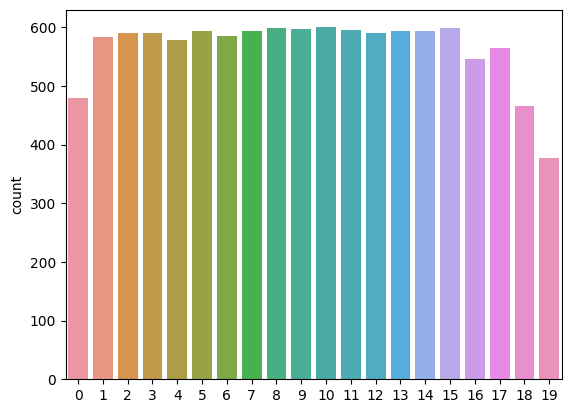

In [6]:
training_plot = sns.countplot(x=sorted(newsgroups_train.target))

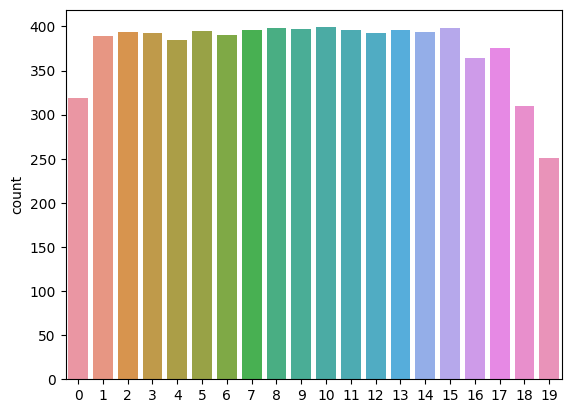

In [7]:
testing_plot = sns.countplot(x=sorted(newsgroups_test.target))

### Preprocessing (Feature extraction)
Nell'NLP il preprocessing consiste nel rimuove le parole stopwords da ogni esempio e calcolare una rappresentazione vettoriale della frase, ad esempio un **vettore TF-IDF** (term frequency / inverse-document-frequency) o un vettore **word embedding**. Nella rappresentazione TF-IDF, ogni frase viene rappresentata da un vettore sparso (con molti 0), in cui i valori non-0 sono in corrispondenza delle parole della frase e rappresentano la loro importanza nella frase, sulla base di tutto il corpus. Al contrario i word embedding sono dei vettori compatti che hanno un valore reale diverso da 0 in ogni elemento e si ottengono da una rete neurale.

Il metodo transform, invece, viene utilizzato per applicare il pre-processore addestrato sui dati di input senza doverlo addestrare di nuovo. In altre parole, questo metodo applica solo la trasformazione dei dati utilizzando il pre-processore addestrato. Questo metodo può essere utilizzato su qualsiasi set di dati, compresi i dati di addestramento, validazione e test.

In generale, si utilizza fit_transform solo sul set di addestramento e transform sui set di validazione e test. Questo perché il set di addestramento viene utilizzato per addestrare il pre-processore, mentre i set di validazione e test vengono utilizzati per valutare le prestazioni del modello addestrato. Addestrare il pre-processore sui dati di validazione e test potrebbe condurre a una valutazione ottimistica del modello e a una scarsa generalizzazione su nuovi dati.

In [8]:
# Extract features from the dataset
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train = tfidf_vectorizer.fit_transform(newsgroups_train.data)
X_test = tfidf_vectorizer.transform(newsgroups_test.data)
y_train = newsgroups_train.target
y_test = newsgroups_test.target

## Matrici sparse
Il metodo vectorizer.fit_transform() calcola i valori tf-idf di ogni parola in ogni frase a partire produce una **matrice sparsa** in cui ogni elemento diverso da 0 e' della forma:

    (numero frase, indice della parola)  valore tf-idf della parola

Inoltre la tupla (numero frase, indice della parola) può essere anche vista come gli indici (riga, colonna) in una rappresentazione a matrice classica (con gli zeri indicati). E' possibile che le stesse parole siano in frasi diverse e in tal caso avranno lo stesso tf-idf. NON SI HA INVECE LO STESSO VALORE PER LA STESSA PAROLA NEI TRANSFORMERS, che tengono conto anche del contesto della frase.

Ad esempio se la frase 0 è composta dalle parole di indice 59071, 57250 e 41874, potremmo avere:

    (0, 59071)	0.10043853867312116 
    (0, 57250)	0.1063473585616558
    (0, 41874)	0.224548896412017

La rappresentazione vettoriale tf-idf della frase 0 è quindi data dal vettore colonna in cui gli unici valori diversi da zero sono i tre elencati sopra:

$$(0,...,0, 0.10043853867312116, 0, ...,0, 0.1063473585616558, 0,...,0, 0.224548896412017, 0, ..., 0)^T$$

In [8]:
print(X_train[:3])

  (0, 59071)	0.10043853867312116
  (0, 57250)	0.1063473585616558
  (0, 41874)	0.224548896412017
  (0, 49800)	0.11869932893481257
  (0, 46690)	0.12504220873599214
  (0, 73174)	0.16142029533900565
  (0, 99608)	0.09418459052541318
  (0, 84050)	0.16329311028814825
  (0, 37208)	0.1434127293323407
  (0, 62594)	0.13037295035007848
  (0, 87913)	0.25808578247347563
  (0, 54493)	0.06961997844491917
  (0, 23430)	0.12937103288512333
  (0, 77676)	0.12197186951739486
  (0, 81450)	0.1461308934288897
  (0, 24583)	0.19644480500804062
  (0, 16806)	0.1407774554706102
  (0, 83208)	0.11339406589538423
  (0, 76269)	0.08978258481915573
  (0, 34742)	0.17300821242559045
  (0, 24108)	0.24723134514216435
  (0, 25437)	0.10548299054214269
  (0, 11174)	0.20599311323287353
  (0, 35902)	0.1266709604197344
  (0, 9843)	0.20797700857530224
  :	:
  (2, 58818)	0.11421411941756535
  (2, 65475)	0.038575837206097384
  (2, 59552)	0.06356310743922607
  (2, 83714)	0.11145632172819905
  (2, 3483)	0.0792685643310162
  (2, 95674)	

We can print the vocabulary to see what is contained inside. It is defined as `key:value` pairs, where the `key` is the word from the texts and the `value` is the index in the matrix for the tf-idf computation.

In [9]:
print(len(tfidf_vectorizer.vocabulary_))

101322


I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

In [10]:
indexs = [59071, 57250, 41874, 49800, 46690, 73174, 99608, 84050, 37208, 62594, 87913, 54493, 23430, 77676, 81450, 24583, 16806, 83208, 76269, 34742, 24108, 25437, 11174, 35902, 9843]

def find_element_in_vocabulary(indexs_vocabulary: list[int], vectorizer: TfidfVectorizer):
    for i in indexs_vocabulary:
        for e in vectorizer.vocabulary_:
            if i==vectorizer.vocabulary_[e]:
                print(e)
                break

print(find_element_in_vocabulary(indexs, tfidf_vectorizer))


mail
looking
funky
info
history
production
years
specs
engine
model
tellme
know
body
rest
separate
bumper
addition
small
really
doors
bricklin
called
70s
early
60s
None


Let's retrieve the score of the word 'wondering'. We need to take the `index` from the vocabulary and then print the corresponding value.

In [11]:
print("The score of the word 'wondering' for a sentence in which it occurs", \
      X_train[0, tfidf_vectorizer.vocabulary_['wondering']])

print("The score of the word 'wondering' for a sentence in which it DOES NOT occur", \
      X_train[1, tfidf_vectorizer.vocabulary_['wondering']])

print("The score of the word 'wondering' for a sentence in which it occurs, but it's less frequent", \
      X_train[2, tfidf_vectorizer.vocabulary_['wondering']])

The score of the word 'wondering' for a sentence in which it occurs 0.13703598126117264
The score of the word 'wondering' for a sentence in which it DOES NOT occur 0.0
The score of the word 'wondering' for a sentence in which it occurs, but it's less frequent 0.06376456586140074


### Support Vector Machines (BoW)

Definition of the model using the Bag-of-Words (tf-idf) formulation from previous exercises in order to compute some hyperplanes for the classification.  

As an example, we would like something like the space in this image (for illustrations purposes only).
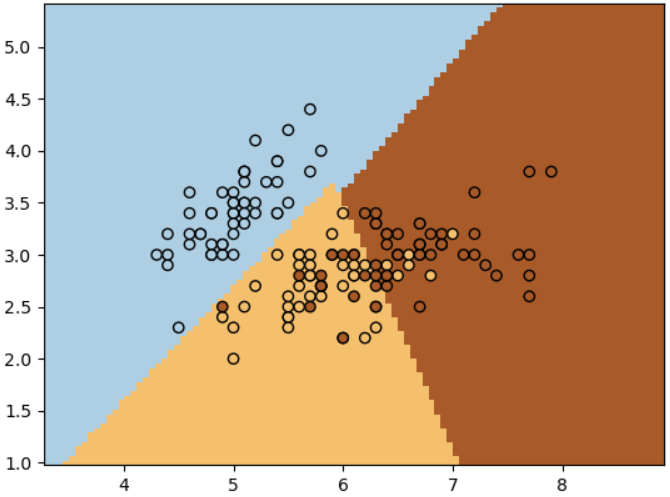

An overview of the main parameters:

- **C**: `float`, default=`1.0`  
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

- **kernel**: `{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}` or callable, default=`'rbf'`  
Specifies the kernel type to be used in the algorithm. If none is given, `‘rbf’` will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape `(n_samples, n_samples)`.

- **degree**: `int`, default=`3`  
Degree of the polynomial kernel function (`‘poly’`). Must be non-negative. Ignored by all other kernels.

- **gamma**: `{‘scale’, ‘auto’}` or `float`, default=`’scale’`  
Kernel coefficient for `‘rbf’`, `‘poly’` and `‘sigmoid’`.

  - if gamma = `'scale'` (default) is passed then it uses `1 / (n_features * X.var())` as value of gamma,
  - if `‘auto’`, uses `1 / n_features`
  - if `float`, must be non-negative.

- **verbose**: `bool`, default=`False`  
Enable verbose output. Note that this setting takes advantage of a per-process runtime setting in libsvm that, if enabled, may not work properly in a multithreaded context.

- **max_iter**: `int`, default=`-1`  
Hard limit on iterations within solver, or `-1` for no limit.

- **decision_function_shape**: `{‘ovo’, ‘ovr’}`, default=`’ovr’`  
Whether to return a one-vs-rest (`‘ovr’`) decision function of shape `(n_samples, n_classes)` as all other classifiers, or the original one-vs-one (`‘ovo’`) decision function of libsvm which has shape `(n_samples, n_classes * (n_classes - 1) / 2)`. However, note that internally, one-vs-one (`‘ovo’`) is always used as a multi-class strategy to train models; an ovr matrix is only constructed from the ovo matrix. The parameter is ignored for binary classification.

Notice that we are using a `linear` version of the SVM model, so the `degree` and `gamma` params will be ignored.

In [12]:
C = 1
decision_function_shape = 'ovo' 
max_iter = 10000
kernel = "linear"
degree = 3
gamma = 0.7

svm = SVC(C=C, max_iter=max_iter, degree=degree, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print(classification_report(y_test, y_pred, target_names=classes))

### EXERCISE 1: Find the best value of C parameter

Find the best value of *C* parameter in order to maximize the F1 score. Use a 10 fold cross-validation policy, save all the scores and plot the mean of the folds for every value. Discuss briefly the results. 

Example: 
- C=0.1: fold_1 = 0.63; fold_2 = 0.66; fold_3 = 0.68; fold_4 = 0.66; fold_5 = 0.68; ... → mean = 0.662
- C=0.2: fold_1 = 0.64; fold_2 = 0.67; fold_3 = 0.69; fold_4 = 0.66; fold_5 = 0.69; ... → mean = 0.67  

Quando si effettua la cross_val_score non bisogna fare il fit del modello poichè è già contenuto all'interno della cross validation.

In [ ]:
c_values = [0.01, 0.1, 0.2, 0.3, 0.5, 1, 1.5, 2, 5, 10]
max_iter = 10000

f1_scores = []
best_score = 0.0
best_c = 0.01
for c in c_values:
    svm = SVC(C=c, max_iter=max_iter, degree=degree, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)

    scores = cross_val_score(estimator=svm, X=X_train[:1000], y=y_train[:1000], cv=10, scoring='f1_weighted')
    scores_mean = scores.mean()
    f1_scores.append(scores_mean)

    if scores_mean > best_score:
        best_score =  scores_mean
        best_c = c
print("Miglior score f1: " + str(best_score) + " con C pari a: " + str(best_c))

Miglior score f1: 0.5549289378387574 con C pari a: 1.5


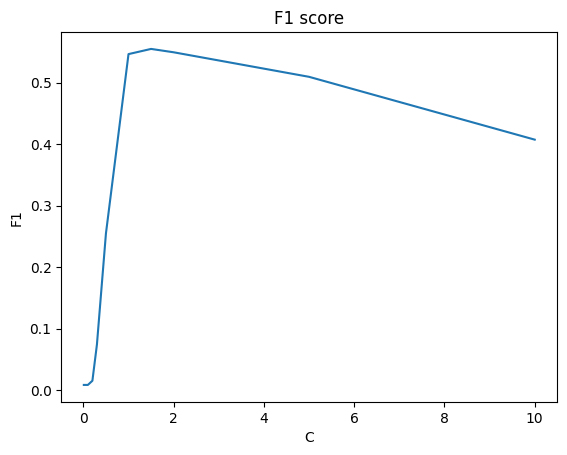

In [ ]:
plt.plot(c_values, f1_scores)
plt.title("F1 score")
plt.xlabel("C")
plt.ylabel("F1")
plt.show()

### EXERCISE 2: Plot the learning curve

Plot the learning curve of the *SVM* model for an increasing size of the training set. Show the F1 score obtained on the test set given the best value of *C* from the previous exercise.

Hint:
- take the **same** test set and value of *C* from the previous exercise
- take increasing sizes of the training set (10%, 20%, ..., 90%, 100%), train the *SVM* model and evaluate it on the test set
- save the performance
- make a plot

In [ ]:
# c = 2

from sklearn.metrics import f1_score


f1_scores = []
percentages = list(map(lambda x: x / 100, range(10, 101, 10)))

for i in percentages:
    # prendiamo i% del dataset e tutto il vocabolario in formato tf-idf
    x_train_percent = X_train[ :int(X_train.shape[0] * i)]
    # prende gli stessi elementi del target 
    y_train_percent = y_train[:int(X_train.shape[0] * i)]
    
    # training e predizione
    svm = SVC(C=best_c, max_iter=max_iter, degree=degree, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)
    svm.fit(x_train_percent, y_train_percent)
    y_pred = svm.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)


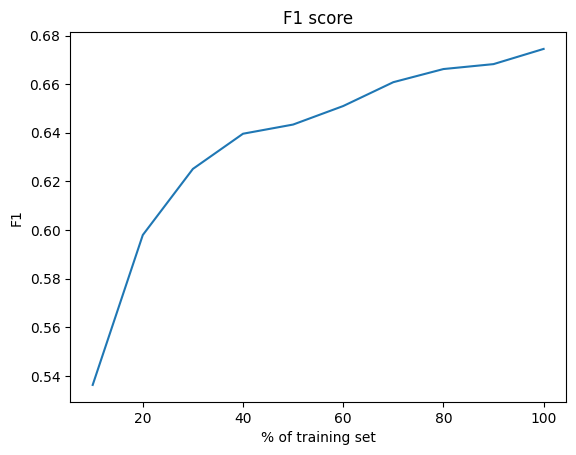

In [ ]:
plt.plot(range(10,101,10), f1_scores)
plt.title("F1 score")
plt.xlabel("% of training set")
plt.ylabel("F1")
plt.show()

# Question Classification dataset
We will use a different dataset, whose objective is to classify the given Questions into respective categories based on what type of answer it expects such as a numerical answer or a text description or a place or human name etc.
Load the dataset and print the classes

In [9]:
training_data = pd.read_csv("./Dataset04svm/train.csv")
testing_data = pd.read_csv("./Dataset04svm/test.csv")

classes_qc = list(np.unique(testing_data['classes'])) # prende tutti i valori univoci delle classi 
print(classes_qc)

print(training_data.shape)

['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']
(5452, 2)


Let's see some examples.

In [10]:
training_data.head(10)

,questions,classes
0,How did serfdom develop in and then leave Russia ?,DESC
1,What films featured the character Popeye Doyle ?,ENTY
2,How can I find a list of celebrities ' real names ?,DESC
3,What fowl grabs the spotlight after the Chinese Year of the Monkey ?,ENTY
4,What is the full form of .com ?,ABBR
5,What contemptible scoundrel stole the cork from my lunch ?,HUM
6,What team did baseball 's St. Louis Browns become ?,HUM
7,What is the oldest profession ?,HUM
8,What are liver enzymes ?,DESC
9,Name the scar-faced bounty hunter of The Old West .,HUM


We can plot the number of examples for each class.

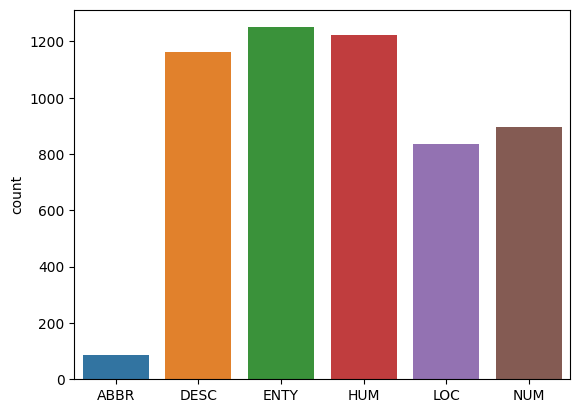

In [11]:
training_plot = sns.countplot(x=sorted(training_data['classes']))

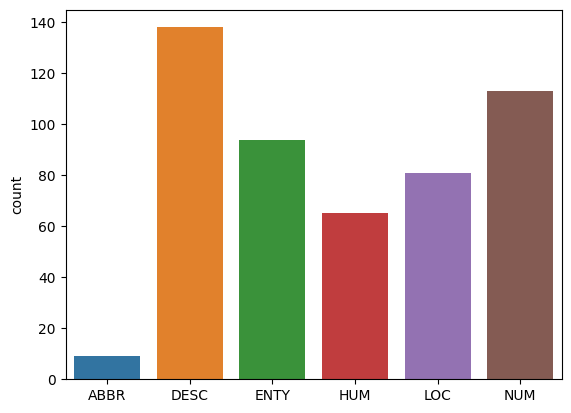

In [12]:
testing_plot = sns.countplot(x=sorted(testing_data['classes']))

### SVM - BoW

Let's apply again the Bag-of-Word (tf-idf) policy to encode these sentences and evaluate an SVM model.

In [13]:
# Extract features from the dataset
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_qc = tfidf_vectorizer.fit_transform(training_data['questions'].tolist())
X_test_qc = tfidf_vectorizer.transform(testing_data['questions'].tolist())
y_train_qc = training_data['classes'].tolist()
y_test_qc = testing_data['classes'].tolist()

print(tfidf_vectorizer.vocabulary_)

print(X_train_qc.shape)
print(X_train_qc)

{'did': 2255, 'serfdom': 6592, 'develop': 2222, 'leave': 4283, 'russia': 6399, 'films': 2940, 'featured': 2884, 'character': 1477, 'popeye': 5721, 'doyle': 2407, 'list': 4388, 'celebrities': 1427, 'real': 6075, 'names': 5019, 'fowl': 3086, 'grabs': 3340, 'spotlight': 6965, 'chinese': 1532, 'year': 8124, 'monkey': 4898, 'form': 3060, 'com': 1701, 'contemptible': 1838, 'scoundrel': 6513, 'stole': 7077, 'cork': 1886, 'lunch': 4482, 'team': 7322, 'baseball': 807, 'st': 6988, 'louis': 4455, 'browns': 1166, 'oldest': 5254, 'profession': 5863, 'liver': 4403, 'enzymes': 2664, 'scar': 6482, 'faced': 2805, 'bounty': 1082, 'hunter': 3716, 'old': 5252, 'west': 7964, 'ozzy': 5366, 'osbourne': 5316, 'born': 1068, 'heavier': 3536, 'objects': 5209, 'travel': 7568, 'downhill': 2403, 'faster': 2858, 'pride': 5820, 'yankees': 8119, 'killed': 4138, 'gandhi': 3185, 'considered': 1817, 'costliest': 1909, 'disaster': 2300, 'insurance': 3878, 'industry': 3828, 'sprawling': 6968, 'state': 7026, 'boasts': 1022,

In [14]:
C = 1
decision_function_shape = 'ovo' 
max_iter = 10000
kernel = "linear"
degree = 3
gamma = 0.7

In [15]:
svm_qc = SVC(C=C, max_iter=max_iter, degree=degree, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)
svm_qc.fit(X_train_qc, y_train_qc)

y_pred_qc = svm_qc.predict(X_test_qc)

print(classification_report(y_test_qc, y_pred_qc, target_names=classes_qc))

              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        DESC       0.70      0.83      0.76       138
        ENTY       0.64      0.53      0.58        94
         HUM       0.62      0.85      0.71        65
         LOC       0.70      0.62      0.66        81
         NUM       0.86      0.70      0.77       113

    accuracy                           0.71       500
   macro avg       0.75      0.72      0.73       500
weighted avg       0.72      0.71      0.71       500



### Support Vector Machines (Neural Encoding)

Adesso vediamo una definizione del modello con una politica differente per la rappresentazione delle frasi.
Recentemente sono stati introdotti da Google dei modelli avanzati, chiamati [Transformers](https://jalammar.github.io/illustrated-transformer/), che sono capaci di rappresentare le parole nel contesto delle loro frasi. Ad esempio sono in grado di distinguere se la parola "bank" viene usata in una frase "*The **bank** of the river.*" o "*I asked the **bank** for a loan*". I Transformers produrranno rappresentazioni differenti della parola **bank** in base al contesto. Invece l'approccio classico bag-of-words (con rappresentazione tf-idf) produrrà la stessa rappresentazione sia per **bank** intesa come lato del fiume sia per l'istituzione finanziaria.

Possiamo sfruttare le capacità dei Transformers per produrre rappresentazioni numeriche delle frasi dai nostri dataset e poi usare un modello come SVM per la classificazione. Il metodo `get_embeddings` chiama il Transformer denominato `'msmarco-distilbert-base-v2'` per ottenere la rappresentazione numerica in modo simile al metodo Vectorizer che abbiamo usato per produrre i vettori `tf-idf`.  

In breve, gli embeddings sono vettori compatti che rappresentano le parole, tenendo conto anche del contesto.

---

**WARNING**: you need to activate the GPU setting for this notebook. If you're using the Jupyter Notebook Environment pass over this, if you're using the Google Colab environment you need to:  
- click on "*Runtime*"
- click on "*Change Runtime type*"
- on "*Hardware accelerator*" choose "*GPU*" from the dropdown list
- click on *Save* and run this Notebook again

Gli embedding sono stati precalcolati e possono essere caricati dai file salvati nella cartella relativa a questa esercitazione. Ma volendo si possono calcolare eseguendo il metodo seguente in una cella codice:

```python
# install the library
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer
import torch

def get_embeddings(sentences: List[str]) -> List[float]:
    model = SentenceTransformer('msmarco-distilbert-base-v2')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    return model.encode(sentences, batch_size=640, device="cuda:0", show_progress_bar=True).tolist()

# X_train_sbert = get_embeddings(newsgroups_train.data)
# X_test_sbert = get_embeddings(newsgroups_test.data)

X_train_sbert = get_embeddings("./Dataset04svm/train.csv")
X_test_sbert = get_embeddings("./Dataset04svm/test.csv")
```

Carichiamo gli embedding dai file, poi stampiamo la prima domanda e il suo corrispondente vettore embedding.

In [19]:
X_train_sbert = []
with open("./Dataset04svm/train_embeddings_sbert.txt") as f:
    lines = f.readlines()
    for line in lines:
        X_train_sbert.append([float(x) for x in line.rstrip().lstrip().split(" ")])
    
X_test_sbert = []
with open("./Dataset04svm/test_embeddings_sbert.txt") as f:
    lines = f.readlines()
    for line in lines:
        X_test_sbert.append([float(x) for x in line.rstrip().lstrip().split(" ")])

Notiamo che tutti i vettori word embedding di ogni frase hanno la stessa dimensione (e.g. 768)

In [20]:
id = 23
print(training_data['questions'].tolist()[id], "\n", X_train_sbert[id],"\n", len(X_train_sbert[id]))
print(training_data['questions'].tolist()[id+1], "\n", X_train_sbert[id+1],"\n", len(X_train_sbert[id+1]))

What 's the Olympic motto ? 
 [0.6862936019897461, 0.2241302877664566, -0.6494758725166321, -0.2815925180912018, -0.5547952055931091, -0.2983439564704895, 0.9571102857589722, 0.3472823202610016, 0.04343600198626518, -0.08492729067802429, -0.2919924557209015, -0.821725606918335, 0.06865915656089783, -0.421497642993927, 0.23417456448078156, -0.08228465914726257, -0.008242401294410229, 0.5064870119094849, 0.5220200419425964, 0.21415290236473083, 0.15017467737197876, 0.3654733896255493, 0.1750464141368866, 0.10121742635965347, 0.6869479417800903, 1.0510766506195068, 0.5958390235900879, 0.13181130588054657, -0.37723055481910706, 0.7086668014526367, -0.17424263060092926, -0.4639996886253357, -0.7342522144317627, 0.6503998637199402, 0.08695585280656815, 0.2732189893722534, -0.29412513971328735, 0.06742261350154877, -0.44016802310943604, 0.025167979300022125, -0.4871479570865631, 0.23298808932304382, 0.763143002986908, -0.8856110572814941, 0.13759203255176544, -0.8504499793052673, 0.4208047389

Ora possiamo addestrare il modello SVM, dando in input il training set formato dagli embedding.

In [21]:
svm_with_sbert = SVC(C=C, degree=degree, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)
svm_with_sbert.fit(X_train_sbert, y_train_qc)

y_pred_qc_sbert = svm_with_sbert.predict(X_test_sbert)

print(classification_report(y_test_qc, y_pred_qc_sbert, target_names=classes_qc))

              precision    recall  f1-score   support

        ABBR       0.62      0.89      0.73         9
        DESC       0.84      0.90      0.87       138
        ENTY       0.79      0.77      0.78        94
         HUM       0.92      0.91      0.91        65
         LOC       0.91      0.88      0.89        81
         NUM       0.97      0.91      0.94       113

    accuracy                           0.87       500
   macro avg       0.84      0.87      0.85       500
weighted avg       0.88      0.87      0.87       500



# Feature selection

L'obiettivo della feature selection è quello di ridurre il numero di feature in input e selezionare quelle che sono più importanti e informative. In effetti il modello Bow introduce **molte** feature (*8181*), escluse le stopwords.

Un modo "semplice" per ridurre le feature è usare la Mutua Informazione (MI): misura la dipendenza mutua tra due variabili aleatorie. In questo contesto, possiamo usare MI per misurare l'ammontare di informazione che una feature (cioè una parola) fornisce su una variabile/classe target. L'idea è che le **feature con MI elevata rispetto alla variabile target** sono più informative di quelle che hanno una bassa MI.

Per applicare la Mutua Informazione alla feature selection, possiamo usare i seguenti passi:
1. Calcolare la MI tra ogni feature e la variabile target
2. Fare un ranking delle feature in ordine decrescente in base ai punteggi di MI
3. Selezionare le prime N feature con i punteggi MI più alti.

Ci sono metodi differenti per calcolare MI, come ad esempio l'uso di metodi basati su entropia o con la divergenza Kullback-Leibler (KL). Nella pratica, la libreria python scikit-learn fornisce diversi metodi per eseguire la feature selection usando la MI, come:

- **mutual_info_classif**: esegue feature selection con mutua informazione per la classificazione. 
- **mutual_info_regression**: esegue feature selection con mutua informazione per la regressione.
- **SelectKBest**: sfrutta le precedenti per prendere le primi k feature più utili

In [86]:
# Questa cella serve solo a dare un metodo che restituisca le feature in modo ordinato (puoi skippare)
from typing import List, Tuple

def argmax(list: List[float]) -> int:
    best_i = 0
    max = 0
    for i in range(len(list)):
        val = list[i]
        if max < val:
            max = val
            best_i = i
    return best_i

def nth_argmax(list: List[float], n) -> int:
    copied = list.copy()

    curr = 0 # current maximum nth
    curr_argmax = 0
    while curr < n:
        curr_argmax = argmax(copied)
        copied[curr_argmax] = 0
        curr += 1
    return curr_argmax

def best_features_selection(list: List[float], n) -> Tuple[List[int], List[float]]:
    top_k_list = []
    top_k_list_indexes = []
    for i in range(1,n+1):
        nth = nth_argmax(list, i)
        top_k_list.append(list[nth])
        top_k_list_indexes.append(nth)
    return top_k_list_indexes, top_k_list

# zip: metto assieme i due array in una lista di tuple
# esempio zip: input [a,b,c] [1,2,3] output: [(a,1), (b,2), (c,3)]
def best_features_selection_zip(list: List[float], n) -> List[Tuple[int, float]]:
    top_k_list = []
    for i in range(1,n+1):
        nth = nth_argmax(list, i)
        top_k_list.append((nth, list[nth]))

    return top_k_list

print(best_features_selection([4,21, 41, 55,22, 11], 2))

([3, 2], [55, 41])


### Mutual information
Applichiamo la feature selection Mutual Information per selezionare i migliori ééelementi del vettore di embedding** da usare come features. In questo caso non abbiamo le parole!!

In [74]:
import sklearn.feature_selection

# proviamo la classificazione mutua sulle question categorization
mutual_info = sklearn.feature_selection.mutual_info_classif(X_train_sbert, y_train_qc)

Gli indici rappresentano gli elementi degli embedding. I vettori hanno 768 dimensione (e non 8000+) e rappresentano le frasi!

In [80]:
# stampa solo i primi k non ordinati
i = 5
print(f"informazione mutua fino alla feature {i}:\n{mutual_info[:i]}")
print("shape del vettore: ", mutual_info.shape)
print(f"elem {argmax(mutual_info)}: ", max(mutual_info))               
print(f"elem {nth_argmax(mutual_info, 2)}: ", mutual_info[nth_argmax(mutual_info, 2)])               
print(f"elem {nth_argmax(mutual_info, 3)}: ", mutual_info[nth_argmax(mutual_info, 3)])               
print(f"elem {nth_argmax(mutual_info, 4)}: ", mutual_info[nth_argmax(mutual_info, 4)])               
print(f"elem {nth_argmax(mutual_info, 5)}: ", mutual_info[nth_argmax(mutual_info, 5)])               


informazione mutua fino alla feature 5:
[0.0456023  0.03405081 0.04771855 0.0232104  0.03190359]
shape del vettore:  (768,)
elem 76:  0.11037880838624936
elem 318:  0.10604983257344047
elem 304:  0.09529252778634145
elem 294:  0.09176851403377873
elem 456:  0.09135616572428162


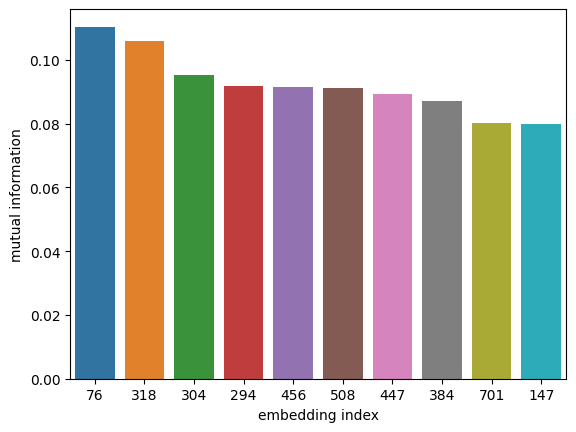

In [102]:
# ordiniamo e stampiamo i k elementi più importanti del vettore word embedding. 
k_best = 10

# [(best embedding index, MI_1), (second best embedding index, MI_2), ...]
zipped = best_features_selection_zip(mutual_info, k_best)
dataframe = pd.DataFrame(zipped)

dataframe.columns = ["embedding index", "mutual information"]
plot = sns.barplot(data=dataframe, x='embedding index', y='mutual information', order=dataframe['embedding index']) # ordino in base al valore di MI

### SelectKBest

In [87]:
from sklearn.feature_selection import SelectKBest
k_best = 10

# fit: fa la feature selection ovvero calcola l'informazione mutua, transform: applica la feature selection al dataset.
kbest = SelectKBest(score_func=sklearn.feature_selection.mutual_info_classif, k=k_best)
kbest_train = kbest.fit_transform(X_train_sbert, y_train_qc)

In [94]:
print("Indici delle migliori feature dell'embedding delle frasi (ordinati per indice crescente) = \n", kbest.get_feature_names_out())
print("Shape: ", (len(X_train_sbert), len(X_train_sbert[0])), "\n")

print(f"I primi 10 scores di {len(kbest.scores_)} non in ordine crescente")
print(kbest.scores_[:10])


Indici delle migliori feature dell'embedding delle frasi (ordinati per indice crescente) = 
 ['x76' 'x147' 'x294' 'x304' 'x318' 'x384' 'x447' 'x456' 'x508' 'x701']
Shape:  (5452, 768) 

I primi 10 scores di 768 non in ordine crescente
[0.0456023  0.03405081 0.04771855 0.0232104  0.031937   0.01778332
 0.0464962  0.02385595 0.00869938 0.03149305]


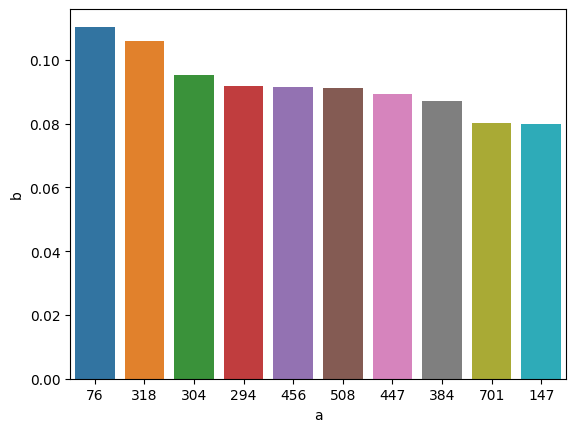

In [107]:
# ordiniamo e stampiamo i k elementi più importanti
best_indexes_and_features = best_features_selection_zip(list(kbest.scores_), k_best)
df = pd.DataFrame(best_indexes_and_features)
df.columns = ['a', 'b'] 
plot = sns.barplot(data=df, x='a', y='b', order=df['a'])

### EXERCISE 3: Select the best Features

Usare la politica di feature selection Mutual Information per dare un punteggio alle feature e selezionare le migliori $K$. Motivare il valore di $K$. Addestra di nuovo il modello SVM e compara le performance rispetto a quello originale.

Giacomo: Il dataset di riferimento scelto è quello di question classification.

Suggerimento: 
1) Estrai prima il vocabolario dal vectorizer (tf-idf oppure word embedding)
2) Calcola dei punteggi per fare il ranking delle feature e mantieni solo le migliori k (feature selection) 
3) Creiamo un vocabolario con le k parole più informative.
4) Aggiorna i dataset lasciando solo le feature selezionate 

``` python
new_vectorizer = TfidfVectorizer(vocabulary=new_vocabulary)
new_X_train = new_vectorizer.transform(X_train)
new_X_test = new_vectorizer.transform(X_test)
```

#### (1) Estrazione del vocabolario iniziale

Produciamo un dizionario con chiave una parola del training set iniziale (eccetto le stopwords) e il valore tf-idf ottenuto dal corpus di frasi del training set.

In [142]:
# Creiamo un nuovo tfidf vectorizer per trasformare le frasi in vettori sparsi coi punteggi tfidf delle parole
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# fit_transform: 
# - fit: addestriamo il vectorizer con il dataset di question classification per ottenere i valori tf-idf di ogni parola
# - transform: otteniamo la matrice TF-IDF dal training set (righe = frasi, colonne = parole, celle = valore tfidf della parola)
X_train_qc = tfidf_vectorizer.fit_transform(training_data['questions'].tolist())

# Trasformiamo anche le frasi del testing set in vettori tf-idf
# non eseguiamo il fit perché non vogliamo addestrare il vettorizzatore sui dati di test.
X_test_qc = tfidf_vectorizer.transform(testing_data['questions'].tolist())

# Salviamoci le colonne target per train e testing set.
y_train_qc = training_data['classes'].tolist()
y_test_qc = testing_data['classes'].tolist()

# Questi sono i nomi delle features (le parole iniziali, escluse le stopwords) per question classification (ABBR, DESC, HUM...)
features_qc = tfidf_vectorizer.get_feature_names_out()

# trasformiamo la matrice di training e di testing per question classification in un dataframe 
# dove ogni colonna corrisponde ad una parola del vocabolario
# cambia la matrice da sparsa a densa.
X_train_df = pd.DataFrame(X_train_qc.toarray(), columns = features_qc) # qua assegnamo i nomi alle colonne
X_test_df = pd.DataFrame(X_test_qc.toarray(), columns = features_qc)

#### (2) Applichiamo la feature selection. 
Scegliamo k=100. E' un buon compromesso tra numero di feature/parole chiave ed è minore delle feature iniziali (8181). Inoltre SVM dovrebbe addestrare più velocemente.

In [186]:
# creiamo un nuovo SelectKBest per la classificazione con politica Mutual Information, che seleziona k_best features
k_best = 4000
selector = SelectKBest(sklearn.feature_selection.mutual_info_classif, k=k_best)
# fit_transform:
# fit: ricaviamo la lista delle migliori k_best features con mutua informazione
# transform: riduciamo il numero di feature a k_best nel training set
selected_x_train_arr = selector.fit_transform(X_train_df, y_train_qc)
# gia che ci siamo facciamo feature selection anche per il testing set
selected_x_test_arr = selector.transform(X_test_df) # qua trasformiamo e basta.


Verifichiamo che la shape sia ridotta nel numero di colonne e stampiamo anche il vocabolario di 100 parole più informative.

In [187]:
# La shape precedente dei dataset:
print(f"old shape training: {X_train_df.shape}, old shape testing: {X_test_df.shape}")
# La shape si è ridotta nel numero di colonne!!
print(f"new shape training: {selected_x_train_arr.shape}, new shape testing: {selected_x_test_arr.shape}\n")
# otteniamo il vocabolario con le features più importanti
selected_vocabulary =  selector.get_feature_names_out()
print(f"Top {k_best} informative words vocabulary:\n{selected_vocabulary}")

old shape training: (5452, 8181), old shape testing: (500, 8181)
new shape training: (5452, 4000), new shape testing: (500, 4000)

Top 4000 informative words vocabulary:
['000' '000th' '103' ... 'zone' 'zones' 'zoological']


Visualizziamo le parole e i punteggi di mutua informazione (attenzione è pesante) 

In [179]:
best_index_skb, best_scores_skb = best_features_selection(selector.scores_, k_best)
if k_best < 100:
    plt.figure(figsize=(15,8))
    plt.xticks(rotation=90)
    sns.barplot(x=X_train_df.columns[best_index_skb], y=best_scores_skb)
else:
    plt.xticks([]) # disabilito i tick alle x
    sns.lineplot(x=X_train_df.columns[best_index_skb], y=best_scores_skb)

KeyboardInterrupt: 

#### (3) Creiamo un vocabolario con le k parole più informative.
Stavolta usiamo direttamente il vocabolario selezionato e nessuna stop_words, visto che sono state già eliminate dal primo vectorizer prima della feature selection.

In [188]:
# Parametri di TfidfVectorizer(max_features, min_df):
# - max_features: permette di costruire un vocabolario che considera solamente le migliori feature ordinate in base al valore di frequenza nel corpus
# - min_df: elimina le parole che appaiono un minimo di volte in un documento; per esempio, se min_df=2 allora elimina le parole che appaiono in meno di due documenti

# creiamo un nuovo vectorizer con il vocabolario formato dalle sole feature più importanti
selected_vectorizer = TfidfVectorizer(vocabulary=selected_vocabulary, stop_words=None) \
                        .fit(training_data['questions'].tolist())

selected_x_train_arr_new = selected_vectorizer.transform(training_data['questions'].tolist()).toarray()
# gia che ci siamo facciamo feature selection anche per il testing set
selected_x_test_arr_new = selected_vectorizer.transform(testing_data['questions'].tolist()).toarray() # qua trasformiamo e basta.



verifichiamo sempre la shape

In [189]:
print(f"Shape of initial  training set: {selected_x_train_arr.shape}: (sentence, word)")
print(f"Shape of selected training set: {selected_x_train_arr_new.shape}: (sentence, word)")

print("initial: ", type(selected_x_train_arr))
print("after: ", type(selected_x_train_arr_new))


Shape of initial  training set: (5452, 4000): (sentence, word)
Shape of selected training set: (5452, 4000): (sentence, word)
initial:  <class 'numpy.ndarray'>
after:  <class 'numpy.ndarray'>


#### (4) Addestriamo il modello con training set ridotto
Usiamo gli stessi parametri di prima, con l'unica differenza che il dataset adesso ha *k_best* features.

In [190]:
C = 1
decision_function_shape = 'ovo' 
max_iter = 10000
kernel = "linear"
degree = 3
gamma = 0.7

svm_fs = SVC(C=C, degree=degree, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)
svm_fs.fit(selected_x_train_arr, y_train_qc)

y_pred_fs = svm_fs.predict(selected_x_test_arr)

print(classification_report(y_test_qc, y_pred_fs, target_names=classes_qc, zero_division=0))

              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        DESC       0.51      0.88      0.64       138
        ENTY       0.60      0.38      0.47        94
         HUM       0.59      0.66      0.62        65
         LOC       0.83      0.43      0.57        81
         NUM       0.78      0.55      0.64       113

    accuracy                           0.61       500
   macro avg       0.72      0.61      0.64       500
weighted avg       0.66      0.61      0.60       500



In [185]:
print("Scores senza effettuare feature selection")
print(classification_report(y_test_qc, y_pred_qc, target_names=classes_qc))

Scores senza effettuare feature selection
              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        DESC       0.70      0.83      0.76       138
        ENTY       0.64      0.53      0.58        94
         HUM       0.62      0.85      0.71        65
         LOC       0.70      0.62      0.66        81
         NUM       0.86      0.70      0.77       113

    accuracy                           0.71       500
   macro avg       0.75      0.72      0.73       500
weighted avg       0.72      0.71      0.71       500



Non ci sono differenze negli score con feature selection e non, indipendentemente si selezionino un numero basso o alto di feature.


### EXERCISE 4: Compare with another model type

Compare the best model you found today (based on *SVM*) with another

In [192]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# Multinomial Naive Bayes model
MultinomialNB_model = MultinomialNB(alpha=0.6)
MultinomialNB_model.fit(selected_x_train_arr_new, y_train_qc)

y_pred_fs = MultinomialNB_model.predict(selected_x_test_arr_new)

print(classification_report(y_test_qc, y_pred_fs, target_names=classes_qc))

              precision    recall  f1-score   support

        ABBR       1.00      0.11      0.20         9
        DESC       0.40      0.13      0.20       138
        ENTY       0.27      0.70      0.39        94
         HUM       0.58      0.57      0.57        65
         LOC       0.68      0.51      0.58        81
         NUM       0.76      0.57      0.65       113

    accuracy                           0.45       500
   macro avg       0.62      0.43      0.43       500
weighted avg       0.54      0.45      0.45       500



In [193]:
# Multivariate Naive Bayes model
BernoulliNB_model = BernoulliNB(alpha=0.3)
BernoulliNB_model.fit(selected_x_train_arr_new, y_train_qc)

y_pred_fs = BernoulliNB_model.predict(selected_x_test_arr_new)

print(classification_report(y_test_qc, y_pred_fs, target_names=classes_qc))

              precision    recall  f1-score   support

        ABBR       0.00      0.00      0.00         9
        DESC       0.50      0.89      0.64       138
        ENTY       0.57      0.34      0.43        94
         HUM       0.61      0.58      0.60        65
         LOC       0.69      0.49      0.58        81
         NUM       0.76      0.54      0.63       113

    accuracy                           0.59       500
   macro avg       0.52      0.47      0.48       500
weighted avg       0.61      0.59      0.57       500



/home/giaco/PycharmProjects/CodiceML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giaco/PycharmProjects/CodiceML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giaco/PycharmProjects/CodiceML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Il migliore finora è SVM senza feature selection!